# CARTaGENE Quebec-wide

The goal of this Jupyter notebook is to compare UMAP projections from realised (genotype) kinship and expected (genealogical) kinship from all CARTaGENE, then isolate the most likely individuals to originate from Saguenay–Lac-Saint-Jean.

In [1]:
from collections import defaultdict
import csv
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import geneakit as gen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.metrics import fowlkes_mallows_score
import umap

The paths to the datasets are found in the *paths.json* file.

In [2]:
with open("../paths.json", 'r') as file:
    paths = json.load(file)

The following DataFrame associates each CARTaGENE ID to a BALSAC ID.

In [3]:
with open(paths['cartagene_balsac_matches'], 'r') as file:
    association_df = pd.read_csv(file, sep=' ')

The following dictionary uses the associations to convert any CARTaGENE ID to its corresponding BALSAC ID.

In [4]:
cag_to_balsac = dict()
for index, (balsac, cartagene) in association_df.iterrows():
    cag_to_balsac[f'{cartagene}_{cartagene}'] = int(balsac)

Let's load the realised (genotype) kinship that was previously computed at step 2.

In [5]:
df = pd.read_csv(paths['wd'] + "results/realised_kinship", index_col=0, sep='\t')

In [6]:
ibd_matrix = df

The following converts the CARTaGENE IDs from the realised kinship matrix to BALSAC IDs and extracts the individuals who have both genotype and genealogical data in the CARTaGENE cohort.

In [7]:
codes = [code for code in sorted(ibd_matrix.index) if code in cag_to_balsac.keys()]
ibd_matrix = ibd_matrix.loc[codes, codes]
inds = [cag_to_balsac[code] for code in codes]
ibd_matrix.index = inds
ibd_matrix.columns = inds
ibd_matrix.sort_index(axis=0, inplace=True)
ibd_matrix.sort_index(axis=1, inplace=True)
inds = sorted(inds)

Let's load the expected (genealogical) kinship that was previously computed in step 4.

In [8]:
with open(paths['wd'] + "results/pickles/cartagene_expected_kinship.pkl", 'rb') as file:
    phi_matrix = pickle.load(file)

The following extracts the CARTaGENE probands who have positive expected kinship with at least half of the other individuals.

In [9]:
temp_matrix = phi_matrix.replace(0, np.nan).copy()
counts = temp_matrix.count()
df = pd.DataFrame()
df['count'] = counts
df = df.groupby('count')['count'].count()
df[df.index > 0.5 * temp_matrix.shape[0]].sum()
pro = [ind for ind in inds if ind in temp_matrix.index]
pro50 = [ind for ind, count in zip(pro, counts) if count > 0.5 * temp_matrix.shape[0]]
del temp_matrix
len(pro50)

8069

The following extracts their corresponding expected kinship matrix and replaces the diagonal with ones.

In [10]:
phi_matrix = phi_matrix.loc[pro50, pro50]
np.fill_diagonal(phi_matrix.values, 1.0)

Same but with the realised kinship matrix.

In [11]:
ibd_matrix = ibd_matrix.loc[pro50, pro50]
np.fill_diagonal(ibd_matrix.values, 1.0)

Now let's identify and remove siblings.

In [12]:
indices_to_drop = np.where(np.triu(phi_matrix.values, k=1) >= 0.2)
ids_to_drop = set(phi_matrix.columns[indices_to_drop[1]])
indices_to_drop = np.where(np.triu(ibd_matrix.values, k=1) >= 0.2)
ids_to_drop.update(set(ibd_matrix.columns[indices_to_drop[1]]))
print(f"Removed {len(ids_to_drop)} siblings.")

Removed 99 siblings.


Remove the siblings from the kinship matrices.

In [13]:
phi_matrix = phi_matrix.drop(list(ids_to_drop), axis=0).drop(list(ids_to_drop), axis=1)

In [14]:
ibd_matrix = ibd_matrix.drop(list(ids_to_drop), axis=0).drop(list(ids_to_drop), axis=1)

In [15]:
pro50 = list(ibd_matrix.index)

Compute the linear regression between the two matrices, using only the upper right triangle.

In [16]:
x = ibd_matrix.values[np.triu_indices_from(ibd_matrix, k=1)]
y = phi_matrix.values[np.triu_indices_from(phi_matrix, k=1)]
result = linregress(x, y)
(result.slope, result.intercept, result.rvalue, result.pvalue)

(0.6403557197322624, 0.0001017520175702669, 0.7788112813617984, 0.0)

Now, let's load the demographical information about the individuals' marriages.

In [17]:
with open(paths['demography_information'], 'rb') as file:
    civil_df = pd.read_csv(file, sep=';', low_memory=False)

The following extracts the municipality codes of the parents' location of marriage.

In [18]:
cities_parents = civil_df.set_index('IndID').loc[pro50].loc[:, 'URBMariageParents'].tolist()
cities_parents = [0 if np.isnan(city) else int(city) for city in cities_parents]
cities_parents[:10]

[2780, 2780, 2780, 2780, 2780, 2780, 2860, 2860, 2860, 2860]

The following converts the municipality codes to regions.

In [19]:
with open(paths['geography_definitions']) as file:
    definition_df = pd.read_csv(file)
cities_parents_df = pd.DataFrame({'UrbIdMariage': cities_parents})
unknown_row = pd.DataFrame({'UrbIdMariage': [0], 'RegionMariage': ['Unknown']})
definition_df = pd.concat([definition_df, unknown_row], ignore_index=True)
result = cities_parents_df.merge(definition_df[['UrbIdMariage', 'RegionMariage']], on='UrbIdMariage', how='left')
region_mariage_list = result['RegionMariage'].tolist()
region_mariage_list[:10]

['Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean']

Let's load the genealogy.

In [20]:
ped = gen.genealogy(paths['balsac_genealogy'])
ped

A pedigree with:
 - 6140246 individuals;
 - 10817946 parent-child relations;
 - 3047310 men;
 - 3092936 women;
 - 3502836 probands;
 - 19 generations.

The following creates dictionaries that are used to convert city and region codes from BALSAC into human-readable name strings.

In [21]:
city_code_to_string = {}
with open(paths['geography_definitions'], 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        UrbMariage, UrbIdMariage, *_ = row
        city_code_to_string[int(UrbIdMariage)] = UrbMariage

region_code_to_string = {
    25705: "Abitibi",
    25706: "Bas-Saint-Laurent",
    25707: "Beauce",
    25708: "Bois-Francs",
    25709: "Charlevoix",
    25710: "Côte-de-Beaupré",
    25711: "Côte-du-Sud",
    25712: "Côte-Nord",
    25713: "Estrie",
    25714: "Gaspésie",
    25715: "Île-de-Montréal",
    25716: "Îles-de-la-Madeleine",
    25717: "Lanaudière",
    25718: "Laurentides",
    25719: "Mauricie",
    25720: "Outaouais",
    25721: "Agglomération de Québec",
    25722: "Région de Québec",
    25723: "Nord du Québec",
    25724: "Richelieu",
    25725: "Rive Nord-Ouest de Montréal",
    25726: "Rive Sud de Montréal",
    25727: "Saguenay–Lac-Saint-Jean",
    25728: "Témiscamingue",
    27118: "Côte-de-Beaupré",
    27119: "Portneuf",
    27120: "Lévis-Lotbinière"
}

The following generates dictionaries for identifying demographical information from an individual and their parents.

In [22]:
city_proband = {}
region_proband = {}
year_proband = {}
city_parent = {}
region_parent = {}

with open(paths['demography_information'], 'r', encoding='cp1252') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Skip header row
    for row in reader:
        if len(row) == 0: break
        IndID, CaG, ERRQ, PereID, MereID, Sexe, PaysOrigine, DateNaissance, RegionNaissance, \
        DateDeces, RegionDeces, DateMariage, ConjointID, URBMariage, RegionMariage, \
        DateMariageParents, URBMariageParents, RegionMariageParents = row

        IndID = int(IndID) if IndID != 'NA' else 0
        URBMariage = int(URBMariage) if URBMariage != 'NA' else 0
        RegionMariage = int(RegionMariage) if RegionMariage != 'NA' else 0
        DateMariage = int(DateMariage) if DateMariage != 'NA' else 0
        URBMariageParents = int(URBMariageParents) if URBMariageParents != 'NA' else 0
        RegionMariageParents = int(RegionMariageParents) if RegionMariageParents != 'NA' else 0

        city_proband[IndID] = city_code_to_string.get(URBMariage, 0)
        region_proband[IndID] = region_code_to_string.get(RegionMariage, 0)
        year_proband[IndID] = DateMariage
        city_parent[IndID] = city_code_to_string.get(URBMariageParents, 0)
        region_parent[IndID] = region_code_to_string.get(RegionMariageParents, 0)

Let's get the region of origin on the fathers' side.

In [23]:
paternal_regions = [region_parent.get(ped[ind].father.ind, "Unknown") for ind in pro50]
paternal_regions[:10]

['Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean']

Let's get the region of origin on the mothers' side.

In [24]:
maternal_regions = [region_parent.get(ped[ind].mother.ind, "Unknown") for ind in pro50]
maternal_regions[:10]

['Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Côte-du-Sud',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Charlevoix',
 'Saguenay–Lac-Saint-Jean']

Now let's compare the origins on both sides and check if there is a match. Those probands with a matching region of origin are most likely to originate from that region and will be used to measure which cluster is most likely to originate from Saguenay–Lac-Saint-Jean.

In [25]:
matched_regions = [paternal_region
                   if paternal_region == maternal_region and paternal_region != "Unknown"
                   else "Mismatch"
                   for paternal_region, maternal_region
                   in zip(paternal_regions, maternal_regions)]
matched_regions[:10]

['Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Mismatch',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Saguenay–Lac-Saint-Jean',
 'Mismatch',
 'Saguenay–Lac-Saint-Jean']

A first UMAP projection is used for clustering.

In [26]:
emb_balsac = umap.UMAP(
    n_components=10,
    min_dist=0.0,
    n_neighbors=15,
    metric='precomputed',
    random_state=0,
    verbose=True
).fit_transform(1-phi_matrix)
emb_balsac

UMAP(metric='precomputed', min_dist=0.0, n_components=10, n_jobs=1, random_state=0, verbose=True)
Mon Sep 22 17:14:54 2025 Construct fuzzy simplicial set
Mon Sep 22 17:14:54 2025 Finding Nearest Neighbors
Mon Sep 22 17:15:10 2025 Finished Nearest Neighbor Search
Mon Sep 22 17:15:13 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 22 17:15:34 2025 Finished embedding


array([[7.124733 , 9.671802 , 1.5186111, ..., 4.4165926, 4.264861 ,
        1.6954057],
       [7.2012715, 9.811009 , 1.4171796, ..., 4.2333965, 4.231746 ,
        1.6703279],
       [7.2266808, 9.734309 , 1.5399835, ..., 4.7297482, 4.2118425,
        1.8776658],
       ...,
       [5.170258 , 7.731607 , 2.0967176, ..., 6.0824313, 4.240037 ,
        3.0588357],
       [7.774426 , 8.665474 , 1.9077338, ..., 5.2348604, 4.114497 ,
        2.1489754],
       [6.5492864, 9.604455 , 2.5627487, ..., 5.875454 , 3.6008642,
        3.3066597]], dtype=float32)

A second UMAP projection is used for visualisation.

In [27]:
umap_balsac = umap.UMAP(
    min_dist=0.5,
    n_neighbors=15,
    metric='precomputed',
    random_state=0,
    verbose=True
).fit_transform(1-phi_matrix)
umap_balsac

UMAP(metric='precomputed', min_dist=0.5, n_jobs=1, random_state=0, verbose=True)
Mon Sep 22 17:15:36 2025 Construct fuzzy simplicial set
Mon Sep 22 17:15:36 2025 Finding Nearest Neighbors
Mon Sep 22 17:15:45 2025 Finished Nearest Neighbor Search
Mon Sep 22 17:15:45 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 22 17:16:00 2025 Finished embedding


array([[10.846869  , -0.71200204],
       [11.389528  , -1.1230428 ],
       [10.083418  , -0.6583676 ],
       ...,
       [ 3.4463391 ,  1.6078862 ],
       [ 9.4696865 ,  0.5712247 ],
       [ 5.949242  , -1.5321997 ]], dtype=float32)

HDBSCAN is used with the parameters from the CARTaGENE paper (https://doi.org/10.1101/2025.05.14.25327536) in order to identify the Saguenay–Lac-Saint-Jean cluster. The Folkes-Mallows score here is used only for indication of the cluster's ability to isolate individuals from SLSJ.

In [28]:
# Step 1: Run HDBSCAN clustering
labels_balsac = HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=0.3).fit_predict(emb_balsac)

# Step 2: Filter out Mismatch entries
valid_indices = [i for i, label in enumerate(matched_regions) if label != "Mismatch"]
valid_labels = [matched_regions[i] for i in valid_indices]
valid_clusters = [labels_balsac[i] for i in valid_indices]

# Step 3: Count how many "Saguenay–Lac-Saint-Jean" are in each cluster
cluster_to_slsj_count = defaultdict(int)
for cluster, label in zip(valid_clusters, valid_labels):
    if label == "Saguenay–Lac-Saint-Jean":
        cluster_to_slsj_count[cluster] += 1

# Step 4: Find the cluster with the most SLSJ individuals
if cluster_to_slsj_count:
    main_slsj_cluster_balsac = max(cluster_to_slsj_count.items(), key=lambda x: x[1])[0]
else:
    main_slsj_cluster_balsac = None  # fallback if no SLSJ labels exist

# Step 5: Construct labels_true and labels_pred
labels_true = ["Saguenay–Lac-Saint-Jean" if label == "Saguenay–Lac-Saint-Jean" else "Other" for label in valid_labels]
labels_pred = ["Saguenay–Lac-Saint-Jean" if cluster == main_slsj_cluster_balsac else "Other" for cluster in valid_clusters]

# Step 6: Compute the Fowlkes-Mallows score
score = fowlkes_mallows_score(labels_true, labels_pred)
print(f"Fowlkes-Mallows score: {score:.6f}. Main cluster: {main_slsj_cluster_balsac}.")


Fowlkes-Mallows score: 0.946033. Main cluster: 4.


The following replicates the steps above but for realised kinship instead of expected kinship.

In [29]:
emb_cartagene = umap.UMAP(
    n_components=10,
    min_dist=0.0,
    n_neighbors=15,
    random_state=0,
    verbose=True
).fit_transform(1-ibd_matrix)
emb_cartagene

UMAP(min_dist=0.0, n_components=10, n_jobs=1, random_state=0, verbose=True)
Mon Sep 22 17:16:03 2025 Construct fuzzy simplicial set
Mon Sep 22 17:16:03 2025 Finding Nearest Neighbors
Mon Sep 22 17:16:03 2025 Building RP forest with 9 trees
Mon Sep 22 17:16:12 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
	 8  /  13
	 9  /  13
	 10  /  13
	Stopping threshold met -- exiting after 10 iterations
Mon Sep 22 17:16:34 2025 Finished Nearest Neighbor Search
Mon Sep 22 17:16:35 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 22 17:16:55 2025 Finished embedding


array([[-1.995899  ,  4.285079  ,  1.0255699 , ...,  2.290483  ,
         6.3535123 ,  6.2479005 ],
       [-1.8539708 ,  4.3369775 ,  1.1644007 , ...,  2.1049025 ,
         6.321998  ,  6.204434  ],
       [-1.9302068 ,  4.3164406 ,  0.98952574, ...,  2.1520867 ,
         6.270754  ,  6.1260924 ],
       ...,
       [ 9.745538  ,  9.371209  ,  0.8552489 , ...,  2.9876812 ,
         6.78966   ,  3.7192059 ],
       [ 9.371009  ,  9.258168  ,  0.18570462, ...,  3.3946512 ,
         7.2178817 ,  3.6037357 ],
       [ 9.914332  ,  8.493945  ,  1.010844  , ...,  2.3085165 ,
         6.598844  ,  3.7876182 ]], dtype=float32)

In [30]:
umap_cartagene = umap.UMAP(
    min_dist=0.5,
    n_neighbors=15,
    metric='precomputed',
    random_state=0,
    verbose=True
).fit_transform(1-ibd_matrix)
umap_cartagene

UMAP(metric='precomputed', min_dist=0.5, n_jobs=1, random_state=0, verbose=True)
Mon Sep 22 17:16:57 2025 Construct fuzzy simplicial set
Mon Sep 22 17:16:57 2025 Finding Nearest Neighbors
Mon Sep 22 17:17:05 2025 Finished Nearest Neighbor Search
Mon Sep 22 17:17:05 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 22 17:17:19 2025 Finished embedding


array([[18.247612 , -4.2650247],
       [17.746986 , -4.836746 ],
       [17.816216 , -3.7317743],
       ...,
       [13.715852 , -0.5266383],
       [18.09966  , -3.5509963],
       [14.523357 ,  0.6371843]], dtype=float32)

In [31]:
# Step 1: Run HDBSCAN clustering
labels_cartagene = HDBSCAN(cluster_selection_epsilon=0.3, min_cluster_size=25).fit_predict(emb_cartagene)

# Step 2: Filter out Mismatch entries
valid_indices = [i for i, label in enumerate(matched_regions) if label != "Mismatch"]
valid_labels = [matched_regions[i] for i in valid_indices]
valid_clusters = [labels_cartagene[i] for i in valid_indices]

# Step 3: Count how many "Saguenay–Lac-Saint-Jean" are in each cluster
cluster_to_slsj_count = defaultdict(int)
for cluster, label in zip(valid_clusters, valid_labels):
    if label == "Saguenay–Lac-Saint-Jean":
        cluster_to_slsj_count[cluster] += 1

# Step 4: Find the cluster with the most SLSJ individuals
if cluster_to_slsj_count:
    main_slsj_cluster_cartagene = max(cluster_to_slsj_count.items(), key=lambda x: x[1])[0]
else:
    main_slsj_cluster_cartagene = None  # fallback if no SLSJ labels exist

# Step 5: Construct labels_true and labels_pred
labels_true = ["Saguenay–Lac-Saint-Jean" if label == "Saguenay–Lac-Saint-Jean" else "Other" for label in valid_labels]
labels_pred = ["Saguenay–Lac-Saint-Jean" if cluster == main_slsj_cluster_cartagene else "Other" for cluster in valid_clusters]

# Step 6: Compute the Fowlkes-Mallows score
score = fowlkes_mallows_score(labels_true, labels_pred)
print(f"Fowlkes-Mallows score: {score:.4f}. Main cluster: {main_slsj_cluster_cartagene}.")

Fowlkes-Mallows score: 0.9486. Main cluster: 0.


Now let's compare both clusters (genotype and genealogies) and extract the individuals who belong to both.

In [32]:
inds_cartagene = [ind for ind, label in zip(pro50, labels_cartagene) if label == main_slsj_cluster_cartagene]
len(inds_cartagene)

1091

In [33]:
inds_cartagene_slsj = [ind for ind in inds_cartagene if region_parent[ind] == "Saguenay–Lac-Saint-Jean"]
len(inds_cartagene_slsj)

597

In [34]:
inds_balsac = [ind for ind, label in zip(pro50, labels_balsac) if label == main_slsj_cluster_balsac]
len(inds_balsac)

1022

In [35]:
inds_balsac_slsj = [ind for ind in inds_balsac if region_parent[ind] == "Saguenay–Lac-Saint-Jean"]
len(inds_balsac_slsj)

574

In [36]:
inds_both = [ind for ind, lab1, lab2 in zip(pro50, labels_cartagene, labels_balsac) if lab1 == main_slsj_cluster_cartagene and lab2 == main_slsj_cluster_balsac]
len(inds_both)

904

In [37]:
inds_both_slsj = [ind for ind in inds_both if region_parent[ind] == "Saguenay–Lac-Saint-Jean"]
len(inds_both_slsj)

564

Save those extracted individuals for the last Jupyter notebook.

In [38]:
with open(paths['wd'] + "results/pickles/cartagene_inds_slsj.pkl", 'wb') as file:
    pickle.dump(inds_both, file)

Now for the UMAP visualizations. Let's assign a colour to each region of Quebec.

In [39]:
region_to_colour = {
    # ─── Greater Montréal cluster ───
    "Île-de-Montréal":                  'steelblue',
    "Rive Nord-Ouest de Montréal":      'darkturquoise',
    "Rive Sud de Montréal":             'darkslategray',
    "Outaouais":                        'saddlebrown',
    "Lanaudière":                       'lightsalmon',
    "Laurentides":                      'palevioletred',

    # ─── Québec City & Estrie ───
    "Région de Québec":                 'navy',
    "Agglomération de Québec":          'darkslateblue',
    "Côte-de-Beaupré":                  'chartreuse',
    "Portneuf":                         'limegreen',
    "Lévis-Lotbinière":                 'seagreen',
    "Côte-du-Sud":                      'springgreen',
    "Estrie":                           'green',

    # ─── Lower St. Lawrence & Gaspé ───
    "Bas-Saint-Laurent":                'yellow',
    "Saguenay–Lac-Saint-Jean":          'crimson',
    "Charlevoix":                       'orangered',
    "Côte-Nord":                        'orange',
    "Gaspésie":                         'fuchsia',
    "Îles-de-la-Madeleine":             'violet',

    # ─── Interior & Far-north ───
    "Abitibi":                          'khaki',
    "Témiscamingue":                    'darkolivegreen',
    "Bois-Francs":                      'slategray',
    "Beauce":                           'olive',
    "Mauricie":                         'blue',
    "Nord du Québec":                   'blueviolet',
    "Richelieu":                        'darkmagenta',

    # ─── Fallback ───
    "Unknown":                          'gainsboro',
}

Figure 1 of the article.

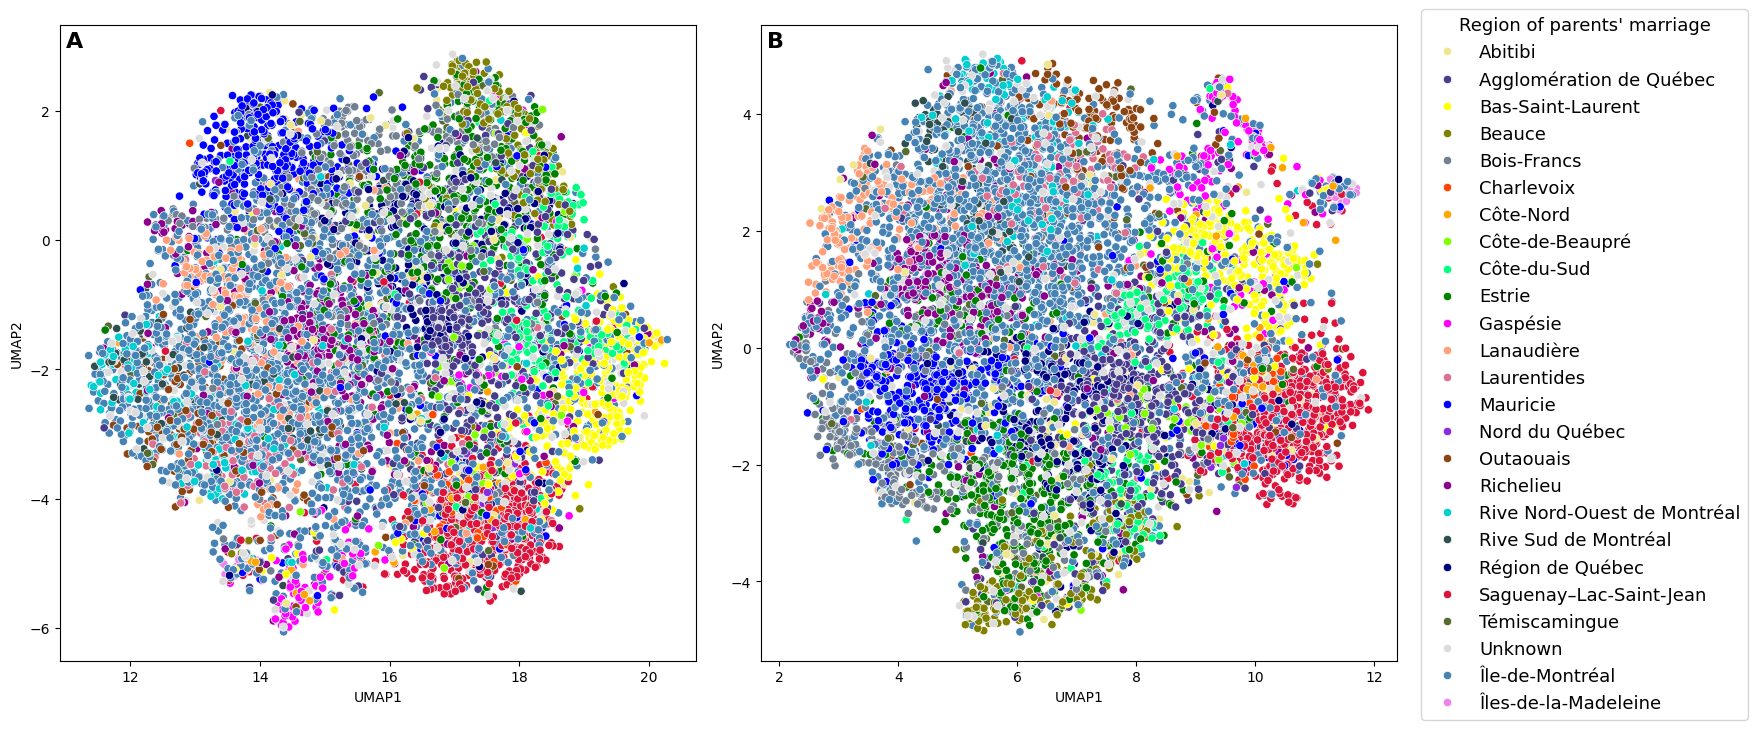

In [40]:
colors = [region for (region, ind) in zip(region_mariage_list, pro50)]

fig, ax = plt.subplots(1, 2, figsize=(180*2/25.4, 90*2/25.4))

# Left subplot: CARTaGENE
sp = sns.scatterplot(
    x=umap_cartagene[:, 0],
    y=umap_cartagene[:, 1],
    hue=colors,
    palette=region_to_colour,
    ax=ax[0]
)

sp.set_xlabel('UMAP1')
sp.set_ylabel('UMAP2')
sp.get_legend().remove()

# Add label "A)" in bold to top-left
ax[0].text(0.01, 0.99, "A", transform=ax[0].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

# Right subplot: BALSAC
sp = sns.scatterplot(
    x=umap_balsac[:, 0],
    y=umap_balsac[:, 1],
    hue=colors,
    palette=region_to_colour,
    ax=ax[1]
)

sp.set_xlabel('UMAP1')
sp.set_ylabel('UMAP2')

# Add label "B)" in bold to top-left
ax[1].text(0.01, 0.99, "B", transform=ax[1].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

# Extract handles and labels BEFORE sorting
handles, labels = sp.get_legend_handles_labels()
color_dict = {label: handle.get_color() for label, handle in zip(labels, handles)}
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# Disable legend
sp.get_legend().remove()

# Add the sorted legend outside the second plot
fig.legend(handles, labels, title="Region of parents' marriage",
    title_fontsize=13, fontsize=13, bbox_to_anchor=(1, 0.5), loc='center left')

plt.tight_layout()
fig.savefig(paths['wd'] + "results/figures/1.CARTaGENEQuebec.svg", bbox_inches='tight')
plt.show()

Supplementary Figure 2 of the article.

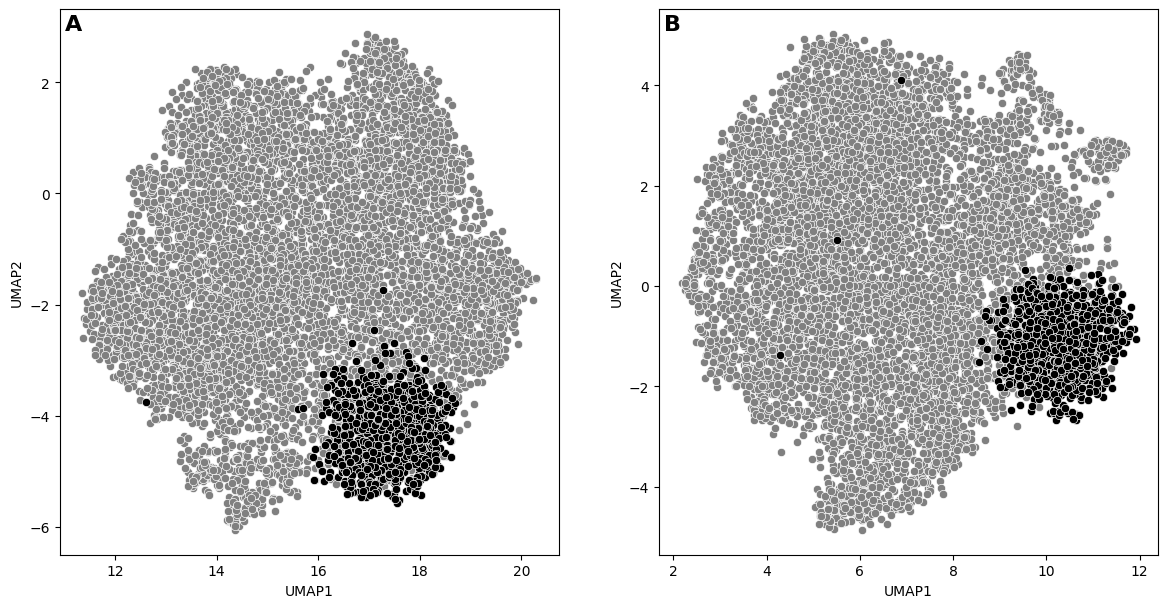

In [41]:
values = [True if ind in inds_both else False for ind in pro50]

fig, ax = plt.subplots(1, 2, figsize=(180*2/25.4, 90*2/25.4))

sp = sns.scatterplot(
    x=umap_cartagene[:, 0],
    y=umap_cartagene[:, 1],
    color='grey',
    ax=ax[0]
)

sp = sns.scatterplot(
    x=umap_cartagene[values, 0],
    y=umap_cartagene[values, 1],
    color='black',
    ax=ax[0]
)

sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Add label "A)" in bold to top-left
ax[0].text(0.01, 0.99, "A", transform=ax[0].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

sp = sns.scatterplot(
    x=umap_balsac[:, 0],
    y=umap_balsac[:, 1],
    color='grey',
    ax=ax[1]
)

sp = sns.scatterplot(
    x=umap_balsac[values, 0],
    y=umap_balsac[values, 1],
    color='black',
    ax=ax[1]
)

sp.set_xlabel(f'UMAP1')
sp.set_ylabel(f'UMAP2')

# Add label "B)" in bold to top-left
ax[1].text(0.01, 0.99, "B", transform=ax[1].transAxes,
           fontsize=16, fontweight='bold', va='top', ha='left')

fig.savefig(paths['wd'] + "results/supp_figures/3.SLSJCluster.svg", bbox_inches='tight')
plt.show()